<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/You_Only_Look_Once_Unified%2C_Real_Time_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **You Only Look Once: Unified, Real-Time Object Detection**

논문 링크: https://arxiv.org/abs/1506.02640

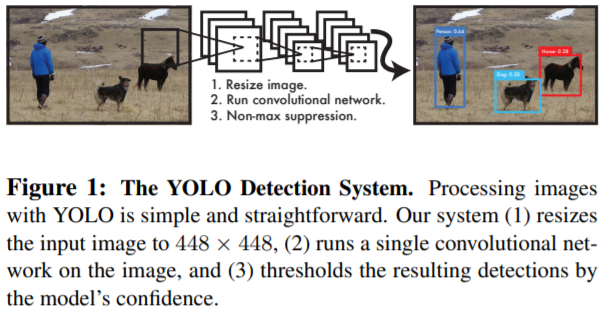

기존 R-CNN과 같은 2-stage detection system들은 복잡한 과정으로 처리 속도가 느리고 최적화가 어려웠다. 하지만 본 논문에서 제안하는 YOLO는 image 내의 bounding box와 class probability를 single regression problem으로 간주하여 본 논문의 제목과 같이 image를 한번만 보고 object의 종류와 위치를 찾아낸다.

## **YOLO 구조**

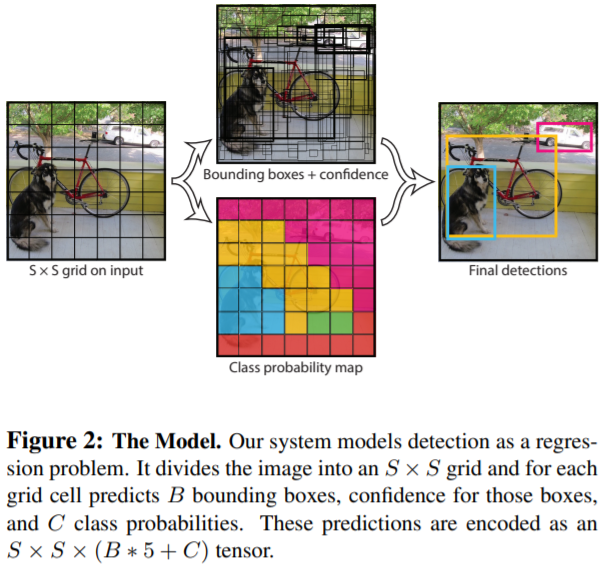

위의 그림 Figure 2와 같이 YOLO는 먼저 input image를 S x S grid로 나눈다.(위의 그림의 경우 7 x 7이다.) 그리고 **각 grid cell은 B개의 bounding box와 각 bounding box에 대한 confidence score를 가지며 동시에 C개의 conditional class probability도 갖는다**.(당연히 만일 cell에 object가 존재하지 않는 경우 confidence score는 0이 된다.) 본 논문에서는 PASCAL VOC dataset을 기준으로 S는 7, B는 2, C는 20이 할당되었다.

그리고 각각의 bounding box는 x,y,w,h,confidence로 구성이 된다. (x,y)는 bounding box의 중심점을 의미하며(grid cell의 범위에 대한 상대값), w와 h는 각각 전체 image의 width와 height(전체 image에 대한 상대값)이다.

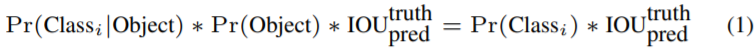

test time에는 위와 같이 conditional class probability와 bounding box의 confidence score를 곱하여 class specific confidence score를 얻는다.

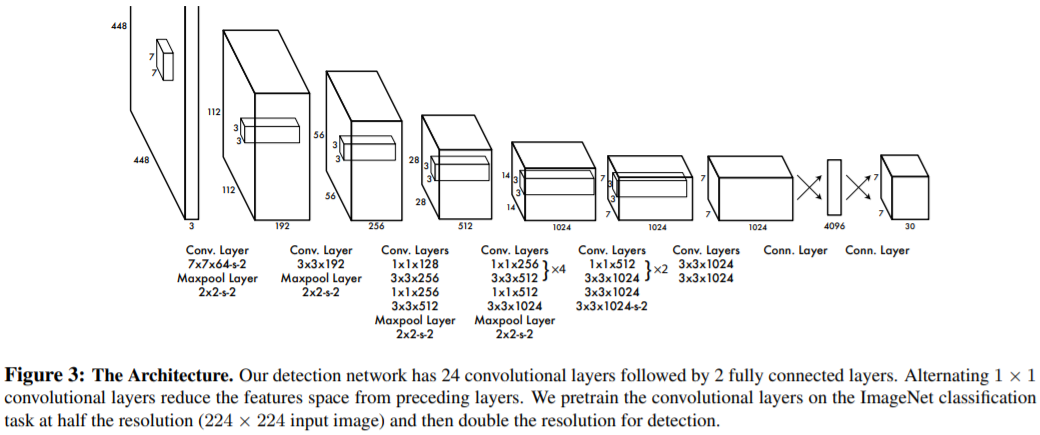

위의 그림 Figure 3은 YOLO의 구조이다. YOLO의 구조는 GoogLeNet를 기반으로 만들어졌으며 최종 output은 7x 7 x 30의 tensor이다. (참고로, Fast YOLO의 경우는 24개 대신 9개의 convolution layer를 사용했다.)

YOLO의 convolution layer 24개 중 앞의 20개는 1000개의 class를 가지는 ImageNet dataset으로 pretrained 시켰다.

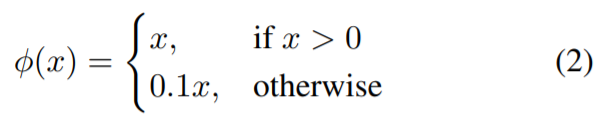

YOLO의 마지막 layer에만 linear activation function을 적용했으며, 나머지 모든 layer에서는 위의 식과 같은 LeakyReLU를 적용하였다.

YOLO의 loss는 SSE(sum-squared error)를 기반으로 한다. 따라서 최종 output의 SSE를 최적화(optimize)하는 것이 목적이다. SSE를 사용한 이유는 최적화하기 쉽기 때문인데, SEE를 최적화하는 것이 mAP를 높이는 것과 완벽하게 일치하지 않는다. 따라서 YOLO의 loss에는 bounding box의 위치를 얼마나 잘 예측했는지에 대한 loss인 localization loss와 class를 얼마나 잘 예측했는지에 대한 classification loss가 있다.

하지만 또 다른 문제가 있는데, image 내 대부분의 grid cell에 object가 없는 것이다. 당연하게도 배경 영역(background region)이 전경 영역(object region)보다 크기 때문이다. **grid cell에 object가 없으면 confidence score는 0이 되는데, 이는 곧 불균형**을 초래한다.

이를 개선하기 위해 object가 존재하는 bounding box 좌표(coordinate)에 대한 loss의 weight를 증가시키고, object가 존재하지 않는 bounding box의 confidence loss에 대한 weight를 감소했다. 이를 위해 사용된 hyper-parameter가 바로 λ_coord와 λ_noobj이다. (본 논문에서는 둘다 0.5로 설정했다.)

SSE의 또 다른 문제는 SSE가 큰 bounding box와 작은 bounding box에 대해 동일한 weight로 loss를 계산하는 것이다. 작은 bounding box가 큰 bounding box보다 작은 위치 변화에 더욱 민감하기 때문에 이를 개선시키기 위하여 width와 height에 square root를 취하였다.

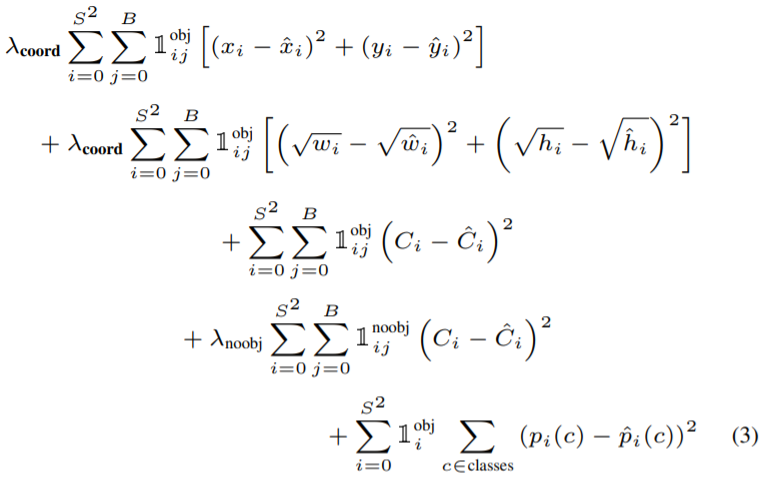

따라서, 최종적인 loss function은 위의 식과 같다. 여기서 1^obj_ij와 1^noobj_ij는 각각 object가 존재하는/존재하지 않는 grid cell i의 predictor bounding box j를 의미하고, 1^obj_i는 object가 존재하는 grid cell i이다.

식을 천천히 풀어보자면,
1. Object가 존재하는 grid cell i의 predictor bounding box j에 대해, x와 y의 loss를 계산한다.
2. Object가 존재하는 grid cell i의 predictor bounding box j에 대해, w와 h의 loss를 계산. 큰 box에 대해서는 small deviation을 반영하기 위해 제곱근을 취한 후, sum-squared error를 한다.(같은 error라도 larger box의 경우 상대적으로 IOU에 영향을 적게 준다.)
3. Object가 존재하는 grid cell i의 predictor bounding box j에 대해, confidence score의 loss를 계산한다. (C_i = 1)
4. Object가 존재하지 않는 grid cell i의 bounding box j에 대해, confidence score의 loss를 계산한다. (C_i = 0)
5. Object가 존재하는 grid cell i에 대해, conditional class probability의 loss 계산. (Correct class c: p_i(c)=1, otherwise: p_i(c)=0)

와 같이 진행이 된다.

## **Experiments**

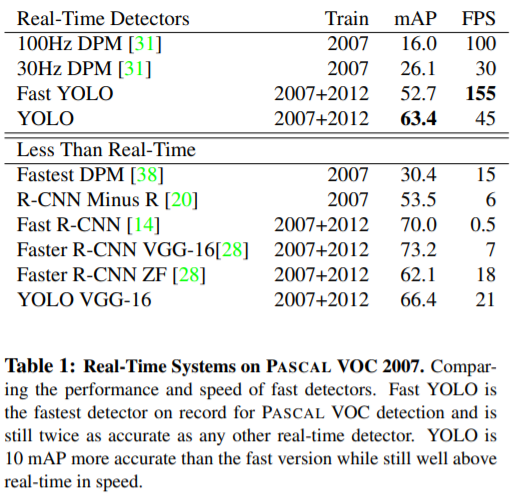

위의 표 Table 1은 PASCAL VOC 2007 dataset에 대해 다른 object detection network와 성능을 비교한 것이다. mAP는 더 낮게 나오지만, FPS가 압도적으로 높은 것을 알 수 있다.

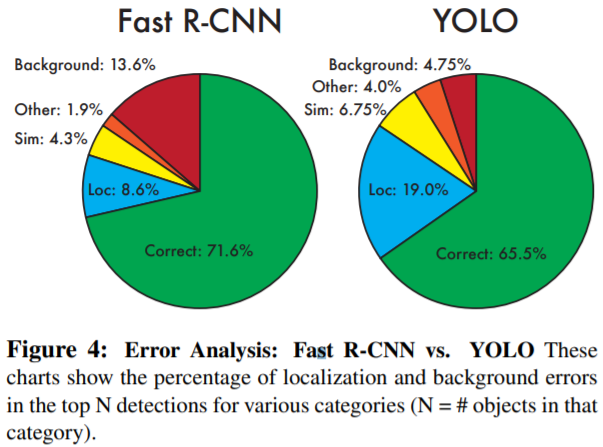

위의 그림 Figure 4는 Fast R-CNN과 YOLO를 원그래프로 비교한 것이다. Fast R-CNN과 비교했을 때, 훨씬 적은 False-Positive를 보여준다.(low background error)

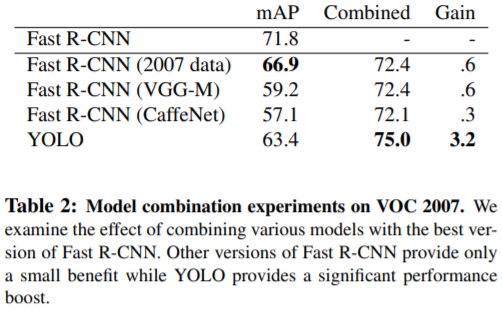

또한 위의 표 Table 2와 같이 Fast R-CNN과 같이 동작하면 Fast R-CNN을 보완해주는 역할을 할 수 있다.

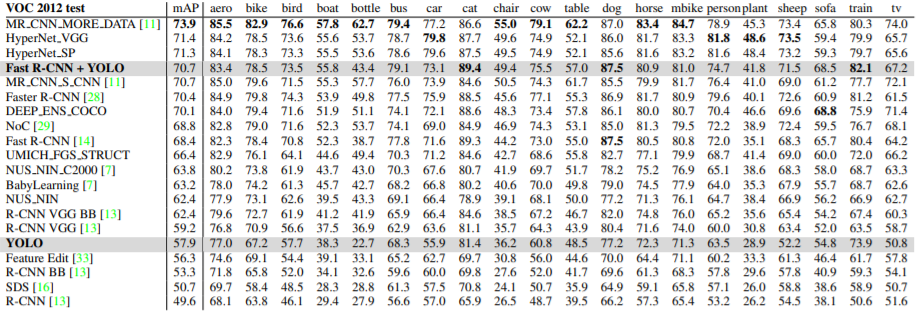

위의 표 Table 3은 VOC 2012 dataset을 기반으로 타 모델들과 비교한 것이다.

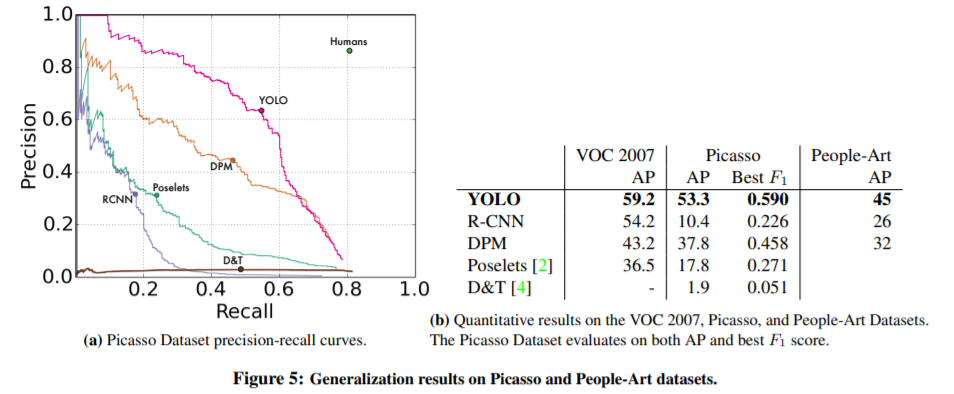

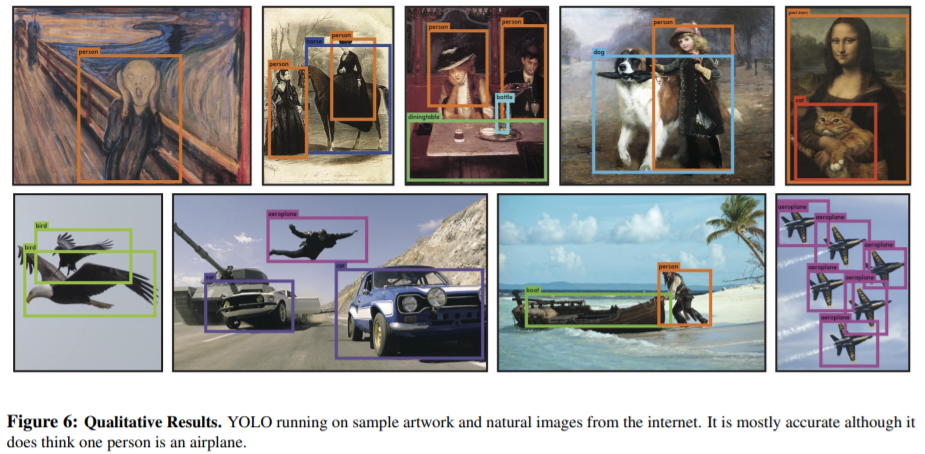

위의 그림들 Figure 5, 6를 보면 natural image로 훈련시킨 것이 Artwork detection에 강한 모습을 보여준다.